In [72]:
import numpy as np
import pandas as pd
import os
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from isotopde_data_v5 import isotopes


In [73]:
#Covert text files into csv
#convert Absorption Cross Section Data
df_abs = pd.read_csv('Absorption_Cross_Section_Data.txt', delim_whitespace=True)
df_abs.to_csv('Absorption_Cross_Section_Data.csv', index=False)

#convert Capture Cross Section Data
df_capture = pd.read_csv('Capture_Cross_Section_Data.txt', delim_whitespace=True)
df_capture.to_csv('Capture_Cross_Section_Data.csv', index=False)

#convert n2n Cross Section Data
df_n2n = pd.read_csv('n2n_Cross_Section_Data.txt', delim_whitespace=True)
df_n2n.to_csv('n2n_Cross_Section_Data.csv', index=False)

#convert Neutron Energy Groups Data
# Read the file with multi-word headers using proper header rows and column names
df_neutron_energy = pd.read_csv(
    'Neutron_Energy_Groups.txt',
    delim_whitespace=True,
    header=None,
    skiprows=1,
    names=[
        'Energy Group',
        'Lower Boundary (eV)',
        'Upper Boundary (eV)'
    ]
)
df_neutron_energy.to_csv('Neutron_Energy_Groups.csv', index=False)


In [74]:
#Create a function to load cross-section data from CSV files
# Here's a corrected version of the function:
def load_cross_section_data(file_path):
    df = pd.read_csv(file_path)
    # Do not set the index, just return the dataframe as a dict
    return df.to_dict(orient='list')

# Load cross-section data
absorption_data = load_cross_section_data('Absorption_Cross_Section_Data.csv')
capture_data = load_cross_section_data('Capture_Cross_Section_Data.csv')
n2n_data = load_cross_section_data('n2n_Cross_Section_Data.csv')

#Build a dictionary for each reaction type
absorption_data = {isotope: data for isotope, data in absorption_data.items() if isotope in isotopes}
capture_data = {isotope: data for isotope, data in capture_data.items() if isotope
in isotopes}
n2n_data = {isotope: data for isotope, data in n2n_data.items() if isotope in isotopes}
# Create a dictionary to hold all cross-section data
cross_section_data = {
    'absorption': absorption_data,
    'capture': capture_data,
    'n2n': n2n_data
}
#print("absorption_data:", absorption_data)
#print("capture_data:", capture_data)
print("n2n_data:", n2n_data)

n2n_data: {'U237': [0.32655, 0.3834, 0.413, 0.46847, 0.5794, 0.65141, 0.71767, 0.78894, 0.84478, 0.9408, 1.1441, 1.2536, 1.4025, 1.5261, 1.585, 1.6091, 1.6161, 1.6103, 1.5953, 1.5716, 1.5354, 1.4833, 1.4144, 1.3221, 1.2432, 1.1667, 0.95301, 0.66218, 0.31005, 0.090021, 0.0042974, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],

In [75]:
# Integrate cross-section data into the isotopes dictionary
for iso in isotopes:
    print(f"Processing isotope: {iso}")
    # Add capture (n, gamma) if available
    if iso in cross_section_data['capture']:
        print(f"Adding capture data for {iso}")
        isotopes[iso]['n_gamma'] = cross_section_data['capture'][iso]
    # Add n,2n if available
    if iso in cross_section_data['n2n']:
        print(f"Adding n2n data for {iso}")
        isotopes[iso]['n_2n'] = cross_section_data['n2n'][iso]
    # Add absorption (n_fission) if available
    if iso in cross_section_data['absorption']:
        print(f"Adding absorption data for {iso}")
        isotopes[iso]['n_fission'] = cross_section_data['absorption'][iso]

print("isotopes:", isotopes)


Processing isotope: U234
Adding absorption data for U234
Processing isotope: U235
Adding capture data for U235
Adding absorption data for U235
Processing isotope: U236
Adding capture data for U236
Adding absorption data for U236
Processing isotope: U237
Adding capture data for U237
Adding n2n data for U237
Processing isotope: U238
Adding absorption data for U238
Processing isotope: U239
Adding capture data for U239
Adding absorption data for U239
Processing isotope: Np236
Adding n2n data for Np236
Adding absorption data for Np236
Processing isotope: Np237
Adding absorption data for Np237
Processing isotope: Np238
Adding capture data for Np238
Adding absorption data for Np238
Processing isotope: Np239
Adding absorption data for Np239
Processing isotope: Pu238
Adding absorption data for Pu238
Processing isotope: Pu239
Adding capture data for Pu239
Adding absorption data for Pu239
Processing isotope: Pu240
Adding capture data for Pu240
Adding absorption data for Pu240
Processing isotope: 

Text(0, 0.5, 'Flux')

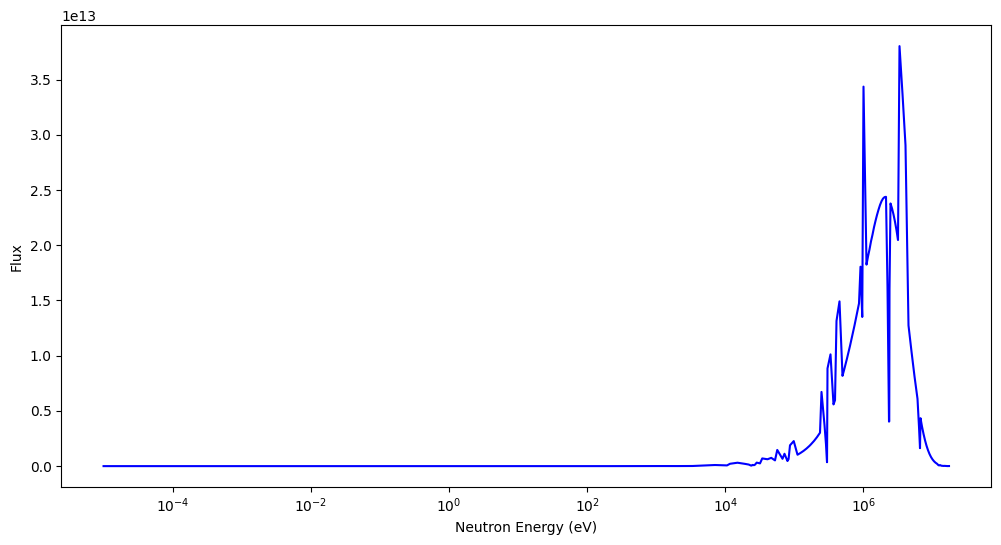

In [76]:
# Load the 175-group flux data
flux = pd.read_csv('Flux.txt', header=None).squeeze().values
#load neutron energy groups
neutron_energy_groups = pd.read_csv('Neutron_Energy_Groups.csv')

#plot neutron energy groups with respect ot flux
plt.figure(figsize=(12, 6))
plt.plot(neutron_energy_groups['Lower Boundary (eV)'], flux, label='Flux', color='blue')
plt.xscale('log')
plt.xlabel('Neutron Energy (eV)')
plt.ylabel('Flux')

In [77]:
#Load Flux (175 - Group vector)
flux_sum = np.sum(flux)

#Load Materials file
materials_df = pd.read_csv('Materials.txt', delim_whitespace=True, header=None, names=['Isotope', 'Concentration'])

####Below is a test code to compute reaction rates based on the flux and isotopes data
#Compute group wise reaction rates
def compute_groupwise_reaction_rates(isotopes, isotope_concentrations, flux, flux_sum):
    """
    Compute group-wise reaction rates for all isotopes in the model.

    Parameters:
        isotopes (dict): Isotope data dictionary.
        isotope_concentrations (dict): {isotope: concentration} for all isotopes (including produced ones).
        flux (np.ndarray): Neutron flux vector.
        flux_sum (float): Sum of flux vector.

    Returns:
        dict: Dictionary with keys 'capture', 'absorption', 'n2n', each mapping to {isotope: rates array}.
    """
    rates = {'capture': {}, 'absorption': {}, 'n2n': {}}
    for isotope, concentration in isotope_concentrations.items():
        if isotope in isotopes:
            # (n, gamma)
            n_gamma = isotopes[isotope].get('n_gamma', 0.0)
            if isinstance(n_gamma, (list, np.ndarray)):
                rates['capture'][isotope] = concentration * flux * np.array(n_gamma) / flux_sum
            else:
                rates['capture'][isotope] = np.zeros_like(flux)
            # (n, fission)
            n_fission = isotopes[isotope].get('n_fission', 0.0)
            if isinstance(n_fission, (list, np.ndarray)):
                rates['absorption'][isotope] = concentration * flux * np.array(n_fission) / flux_sum
            else:
                rates['absorption'][isotope] = np.zeros_like(flux)
            # (n,2n)
            n_2n = isotopes[isotope].get('n_2n', 0.0)
            if isinstance(n_2n, (list, np.ndarray)):
                rates['n2n'][isotope] = concentration * flux * np.array(n_2n) / flux_sum
            else:
                rates['n2n'][isotope] = np.zeros_like(flux)
        else:
            print(f"Warning: Isotope '{isotope}' not found in the isotope model.")
    return rates

# Example usage:
# Build a concentration dictionary for all isotopes (including produced ones)
# For initial materials: 
initial_concentrations = {row['Isotope']: row['Concentration'] for _, row in materials_df.iterrows()}
reaction_rates = compute_groupwise_reaction_rates(isotopes, initial_concentrations, flux, flux_sum)

#test the reaction rates
"""print("Reaction Rates:")
for reaction_type, rates in reaction_rates.items():
    print(f"{reaction_type}:")
    for isotope, rate in rates.items():
        print(f"  {isotope}: {rate}")"""
        

'print("Reaction Rates:")\nfor reaction_type, rates in reaction_rates.items():\n    print(f"{reaction_type}:")\n    for isotope, rate in rates.items():\n        print(f"  {isotope}: {rate}")'

In [78]:
#Convert cross secton data frrame to dict of arrays for quick lookup
def cross_section_lookup(isotope, reaction_type, group):
    """
    Lookup cross-section value for a given isotope, reaction type, and energy group.
    """
    if isotope in isotopes and reaction_type in isotopes[isotope]:
        return isotopes[isotope][reaction_type][group]
    else:
        raise ValueError(f"Cross-section data for {isotope} with reaction type {reaction_type} not found.")
    

#build isotope list and idex list
isotope_list = list(isotopes.keys())
index_map = {iso: i for i, iso in enumerate(isotope_list)}

#intial conditions from amterial file
N0 = np.zeros(len(isotope_list))
for index, row in materials_df.iterrows():
    iso = row['Isotope']
    amount = row['Concentration']
    if iso in index_map:
        N0[index_map[iso]] = amount
    else:
        print(f"Warning: Isotope '{iso}' not found in the isotope model.")

In [112]:

# Define the ODE system
def odes(t, N):
    """
    ODE system for burnup model using groupwise reaction rates.
    N: vector of concentrations for each isotope.
    Only initial materials and their subsequent isotopes (as defined by the 'prod' chain) are included.
    """
    dNdt = np.zeros_like(N)

    # Build current concentrations dict for reaction_rates lookup
    current_conc = {iso: N[index_map[iso]] for iso in isotope_list}

    # Compute groupwise reaction rates at this step
    rates = compute_groupwise_reaction_rates(isotopes, current_conc, flux, flux_sum)

    for iso in isotope_list:
        i = index_map[iso]
        # Loss terms: sum over all groups
        n_gamma_loss = np.sum(rates['capture'].get(iso, 0.0))
        n_fission_loss = np.sum(rates['absorption'].get(iso, 0.0))
        n_2n_loss = np.sum(rates['n2n'].get(iso, 0.0))
        decay = isotopes[iso].get('decay', 0.0)

        dNdt[i] -= (n_gamma_loss + n_fission_loss + n_2n_loss)  # already includes N[i]
        dNdt[i] -= decay * N[i]

        # Production from parent isotopes (as defined in 'prod')
        for parent, reaction in isotopes[iso].get('prod', []):
            j = index_map[parent]
            parent_rate = 0.0
            if reaction == 'n_gamma':
                parent_rate = np.sum(rates['capture'].get(parent, 0.0))
            elif reaction == 'n_2n':
                parent_rate = np.sum(rates['n2n'].get(parent, 0.0))
            elif reaction == 'n_fission':
                parent_rate = np.sum(rates['absorption'].get(parent, 0.0))
            elif reaction == 'decay':
                parent_rate = isotopes[parent].get('decay', 0.0) * N[j]
            dNdt[i] += parent_rate

  

    return dNdt



In [115]:
# Define the burnup model parameters
years = float(input("Enter burnup duration in years (e.g., 10): "))
T_end = years * 365.25 * 24 * 3600  # convert
# years to seconds
# Time evaluation points
t_eval = np.linspace(0, T_end, 1000)

#call the ODE solver
sol = solve_ivp(odes, [0, T_end], N0, t_eval=t_eval, method='BDF')
# Ensure all concentrations are non-negative
sol.y = np.abs(sol.y)
# Output the final concentrations
for i, iso in enumerate(isotope_list):
    val = sol.y[i][-1]
    print(f"{iso}: {val:.4e}")
    

U234: 4.1966e-90
U235: 5.9745e-93
U236: 3.3794e-89
U237: 1.3168e-48
U238: 8.5796e-89
U239: 0.0000e+00
Np236: 0.0000e+00
Np237: 7.1229e-52
Np238: 0.0000e+00
Np239: 0.0000e+00
Pu238: 0.0000e+00
Pu239: 0.0000e+00
Pu240: 0.0000e+00
Pu241: 0.0000e+00
Pu242: 0.0000e+00
Pu243: 0.0000e+00
Am241: 0.0000e+00
Am242: 0.0000e+00
Am243: 0.0000e+00
Cm242: 0.0000e+00
